# Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft, rfftfreq
from IPython.display import display, clear_output
from statistics import variance

# Configuration & Parameters

In [2]:
# Data Selection
DATA_FOLDER_NAME = 'GT_3_18'  # Options: 'GT_0_80', 'GT_3_18'

# Physics
GRAVITY = 9.81

# Ensemble Kalman Filter Parameters
N_CYCLES      = 1200          # Number of cycles
ENSEMBLE_SIZE = 100           # Ensemble Size (Ne)
INFLATION     = 1.015         # Inflation factor
LOCALIZATION_RANGE_RATIO = 0.08 # Fraction of domain length for localization
SIGMA_ETA     = 0.05          # Measurement noise [m]

# Observation Locations [m]
OBS_LOCATIONS = np.array([40.0, 253.0, 412.0])

# Filter / Dealiasing
CUTOFF_FRAC   = 0.5           # Cutoff fraction
DAMP_STRENGTH = 3             # Damping strength
SEED          = 0             # Random seed

# Helper Functions

In [3]:
def make_k_omega_grid(x, g=GRAVITY):
    """Generate k-space grid and omega following deep water dispersion."""
    x = np.asarray(x).ravel()
    N = x.size
    dx = x[1] - x[0]
    k = 2 * np.pi * rfftfreq(N, d=dx)   # k>=0
    omega = np.sqrt(g * np.abs(k))      # deep water dispersion relation
    return k, omega, dx

# FILTER NOT UP TO DATE WITH PAPER 
def make_filter(N, cutoff_frac=0.5, damp_strength=3):       
    """Damping + Cutoff filter."""
    kmax = N // 2
    kc = damp_strength * kmax                       # Filter strength, higher constant = less filtering
    indices = np.arange(N // 2 + 1)
    gauss = np.exp(-0.5 * (indices / kc)**2)        # Gaussian shape for no particular reason
    m = N // 2 + 1
    cutoff = int(cutoff_frac * (m - 1))             # Cutoff idex at cutoff fraction
    mask = np.zeros(m)
    mask[:cutoff + 1] = 1.0
    return mask * gauss
# FILTER NOT UP TO DATE WITH PAPER 

def lwt_step_eta(eta, omega, k, dt, hat_mask=None):
    """Propagate wave surface forward in time via LWT."""
    N = eta.size
    eh = rfft(eta)

    if hat_mask is not None:
        eh *= hat_mask

    a = (2 / N) * np.abs(eh)        # Amplitudes
    Us = np.sum(a**2 * k * omega)   # Stokes Drift Magnitude
    eh *= np.exp(-1j * (omega + 0.5 * Us * k) * dt)
    return irfft(eh, n=N)

def gaspari_cohn(r):
    """Gaspari-Cohn tapering function."""
    r = np.abs(r)
    out = np.zeros_like(r)
    mask_a = r <= 1.0
    mask_b = (r > 1.0) & (r < 2.0)
    ra = r[mask_a]
    rb = r[mask_b]
    out[mask_a] = 1 - (5/3)*ra**2 + (5/8)*ra**3 + 0.5*ra**4 - 0.25*ra**5
    out[mask_b] = ((2 - rb)**5) / 12.0
    return np.clip(out, 0.0, 1.0)

def periodic_dist(a, b, L):
    """Distance in periodic domain."""
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    return ((a[:, None] - b[None, :]) + 0.5 * L) % L - 0.5 * L

def enkf_update_eta(X, y_obs, R, *, x_grid, idx_obs, Lc=None, rng=None):
    """EnKF Analysis Step."""
    N, Ne = X.shape
    M = idx_obs.size
    if rng is None: rng = np.random.default_rng()

    # Analysis Step
    Yf = X[idx_obs, :]                                         # Forecast at probe locations (M, Ne)
    xf = X.mean(axis=1, keepdims=True)                         # Ensemble mean (N,1)
    yf = Yf.mean(axis=1, keepdims=True)                        # Ensemble mean at probe locations (M,1)
    A = X - xf                                                 # Distance from mean
    D = Yf - yf                                                # Distance from mean at ensemble locations
    Eps = rng.multivariate_normal(np.zeros(M), R, size=Ne).T   # Measurement Noise with covariance R
    Ytil = y_obs.reshape(M, 1) + Eps                           # Perturbed Observations
    S = (D @ D.T) / (Ne - 1) + R                               # Innovation Covariance 
    Cxo = (A @ D.T) / (Ne - 1)                                 # Cross Covariance

    if Lc is not None:                                         # Localization
        L = N * (x_grid[1] - x_grid[0])
        d = periodic_dist(x_grid, x_grid[idx_obs], L) / Lc
        rho = gaspari_cohn(d)
        Cxo = Cxo * rho
    
    K = Cxo @ np.linalg.solve(S, np.eye(M))                    # Calculate Kalman Gain
    return X + K @ (Ytil - Yf)                                 # Calculate Updated State

# Data Loading & Initialization

In [4]:
current_notebook_dir = os.getcwd()
data_dir = os.path.join(current_notebook_dir, DATA_FOLDER_NAME)

# Load data
eta_true_raw = np.load(os.path.join(data_dir, 'wavefield_eta_data.npy'))
t_axis = np.load(os.path.join(data_dir, 'solution_times.npy'))
x_axis = np.load(os.path.join(data_dir, 'x_coordinates.npy'))

# Process grid
ETA_TRUE_XT = np.asarray(eta_true_raw[:, 0, :])
x = np.asarray(x_axis).ravel()
N = x.size
k, omega, dx = make_k_omega_grid(x, g=GRAVITY)
Lx = dx * N
dt = t_axis[1] - t_axis[0]

# Wave Height
Hs = np.sqrt(variance(ETA_TRUE_XT[:, 0])) * 4
print("Initialized. Hs =", Hs)

# EnKF Setup
idx_obs = np.round(OBS_LOCATIONS / dx).astype(int)
M = idx_obs.size
R = (SIGMA_ETA**2) * np.eye(M)
Lc = LOCALIZATION_RANGE_RATIO * Lx
hat_mask = make_filter(N, cutoff_frac=CUTOFF_FRAC, damp_strength=DAMP_STRENGTH)

# Ensemble Init
rng = np.random.default_rng(SEED)
X = (Hs / 20) * rng.normal(size=(N, ENSEMBLE_SIZE))
X -= X.mean(axis=0, keepdims=True)

Initialized. Hs = 3.18522655726575


# Main Loop

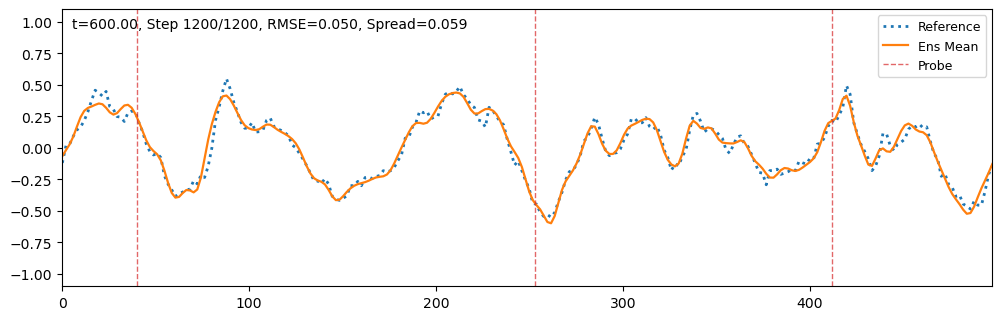

Final RMSE: 0.1601


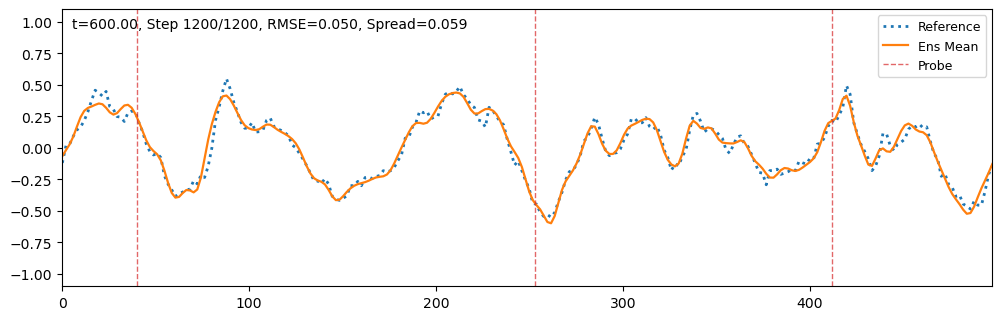

In [5]:
# Live plot code
plt.ion()
fig, ax = plt.subplots(figsize=(12, 3.6))
line_true, = ax.plot(x, ETA_TRUE_XT[:, 0]/Hs, ":", lw=2, label="Reference")
line_mean, = ax.plot(x, X.mean(axis=1)/Hs, lw=1.6, label="Ens Mean")
for i, xo in enumerate(OBS_LOCATIONS):
    ax.axvline(xo, color="tab:red", ls="--", lw=1, alpha=0.7, label="Probe" if i==0 else None)
ax.set_xlim(x[0], x[-1])
ax.set_ylim(-1.1, 1.1)
ax.legend(loc="upper right", fontsize=9)
stats_txt = ax.text(0.01, 0.97, '', transform=ax.transAxes, va='top', ha='left')
rmse_hist = []

# EnKF loop
for n in range(N_CYCLES):
    # Forecast
    for j in range(ENSEMBLE_SIZE):
        X[:, j] = lwt_step_eta(X[:, j], omega, k, dt, hat_mask=hat_mask)

    # Observation
    eta_t = ETA_TRUE_XT[:, n+1]
    y_obs_val = eta_t[idx_obs] + rng.normal(0.0, SIGMA_ETA, size=M)

    # Analysis
    X = enkf_update_eta(X, y_obs_val, R, x_grid=x, idx_obs=idx_obs, Lc=Lc, rng=rng)

    # Inflation and zero mean
    mu = X.mean(axis=1, keepdims=True)
    X = mu + INFLATION * (X - mu)
    X -= X.mean(axis=0, keepdims=True)

    # Metrics
    ens_mean = X.mean(axis=1)
    rmse = np.sqrt(np.mean((ens_mean - eta_t)**2))
    rmse_hist.append(rmse)

    if (n + 1) % 20 == 0:
        spr = np.sqrt(np.mean(np.var(X, axis=1, ddof=1)))
        stats_txt.set_text(f"t={t_axis[n+1]:.2f}, Step {n+1}/{N_CYCLES}, RMSE={rmse/Hs:.3f}, Spread={spr:.3f}")
        line_true.set_ydata(eta_t / Hs)
        line_mean.set_ydata(ens_mean / Hs)
        fig.canvas.draw_idle()
        fig.canvas.flush_events()
        clear_output(wait=True); display(fig)

print(f"Final RMSE: {rmse:.4f}")